# Clone yolov5

In [4]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


# install requirments

In [6]:
!pip install -r ./yolov5/requirements.txt
!pip install albumentations

ERROR: Could not find a version that satisfies the requirement gitpython>=3.1.30 (from versions: 0.1.7, 0.2.0b1, 0.3.0b1, 0.3.0b2, 0.3.1b2, 0.3.2rc1, 0.3.2, 0.3.2.1, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.3.7, 1.0.0, 1.0.1, 1.0.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9.dev0, 2.0.9.dev1, 2.0.9, 2.1.0, 2.1.1, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.1.7, 2.1.8, 2.1.9, 2.1.10, 2.1.11, 2.1.12, 2.1.13, 2.1.14, 2.1.15, 3.0.0, 3.0.1, 3.0.2, 3.0.3, 3.0.4, 3.0.5, 3.0.6, 3.0.7, 3.0.8, 3.0.9, 3.1.0, 3.1.1, 3.1.2, 3.1.3, 3.1.4, 3.1.5, 3.1.6, 3.1.7, 3.1.8, 3.1.9, 3.1.10, 3.1.11, 3.1.12, 3.1.13, 3.1.14, 3.1.15, 3.1.16, 3.1.17, 3.1.18, 3.1.19, 3.1.20)
ERROR: No matching distribution found for gitpython>=3.1.30
     |████████████████████████████████| 21.6 MB 10.2 MB/s            
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached scikit_image-0.17.2-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached networ

# import Libraries & setup matplotlib

In [8]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import os
import urllib
import PIL.Image as Image
import torch
import shutil
import yaml
import cv2
import random
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
np.random.seed(42)


# Reading annotations file

In [13]:
file_path = '/mnt/irisgpfs/users/ngozalpour/CAD project/Data/sim_data_annotations.json'
with open(file_path) as f:
    my_dict = yaml.safe_load(f)
    
    
print(len(my_dict))

277


# Find distinct categories in dataset

In [19]:
categories = []
for c in my_dict:
  for a in c['annotations']:
    categories.append(a['class'])

#print(categories)
categories = list(set(categories))
#print(categories)
categories.sort()
categories

['Green', 'Red', 'Yellow']

# Split dataset to train and test sets

In [20]:
train_imgs, val_imgs = train_test_split(my_dict, test_size=0.1)
print('train samples: {}, validation samples: {}'.format(len(train_imgs),len(val_imgs)))

train samples: 249, validation samples: 28


# Create datasets For training model

In [21]:
def create_dataset(imgs, categories, dataset_type):
  # create folders for images and labels  
  images_path = Path(f"Data/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)
  labels_path = Path(f"Data/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(tqdm(imgs)):
    #get imgage address from json file
    img_src = "Data/"+row['filename']
    img_name = row['filename'][17:]
    img_id = row['filename'][17:-4]

    #copy image to folder
    shutil.copyfile(img_src, str(images_path / img_name))

    #extract labels and transform position object
    label_name = f"{img_id}.txt"
    with (labels_path / label_name).open(mode="w") as label_file:
      for a in row['annotations']:
          category_idx = categories.index(a['class'])
          xmin = a['xmin']/800.0
          ymin = a['ymin']/600.0
          bbox_width = a['x_width']/800.0
          bbox_height = a['y_height']/600.0
          label_file.write(
            f"{category_idx} {xmin + bbox_width / 2} {ymin + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

main_addrs = "/mnt/irisgpfs/users/ngozalpour/CAD project/"        
create_dataset(train_imgs, categories, 'train')
create_dataset(val_imgs, categories, 'val')


100%|██████████| 28/28 [00:00<00:00, 358.35it/s]


# Train Model using created dataset

In [23]:
%cd yolov5
!python train.py --img 640 --cfg yolov5s.yaml --batch 8 --epochs 100 --data Lights.yaml --weights yolov5s.pt  --name yolo_lights


/mnt/aiongpfs/users/ngozalpour/CAD project/yolov5
WARNING ⚠️ Python 3.7.0 is required by YOLOv5, but Python 3.6.8 is currently installed
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=Lights.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolo_lights, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 278 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
WARNING ⚠️ Python 3.7.0 is required by YOLOv5, but Python 3.6.8 is currently installed
fatal: cannot change to '/mnt/aiongpfs/us


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       7/99      2.12G    0.05662    0.01771    0.02097         20        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.589      0.899      0.772      0.374

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       8/99      2.12G     0.0496    0.01687    0.01851         17        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.675      0.896      0.835      0.347

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/99      2.12G     0.0482    0.01623    0.01713         18        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.715      0.841      0.878       0.48

      Epo


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      32/99      2.12G    0.03018    0.01156    0.00468         10        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.976      0.997      0.994      0.695

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      33/99      2.12G    0.02934     0.0106   0.004441         11        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.964      0.995       0.99      0.729

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/99      2.12G    0.02866     0.0115   0.003997         15        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.974      0.997      0.994      0.732

      Epo


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      57/99      2.12G    0.02312    0.00973    0.00192         21        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188       0.98      0.997      0.994      0.756

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      58/99      2.12G    0.02326    0.00984   0.001636         17        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.977      0.995      0.994      0.768

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      59/99      2.12G    0.02252    0.01027   0.001773         18        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.976      0.994      0.994      0.762

      Epo


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      82/99      2.12G    0.01939   0.009656   0.001147         18        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.981      0.994      0.994      0.774

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      83/99      2.12G    0.01841    0.00905   0.001128         17        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188       0.98      0.997      0.994      0.769

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      84/99      2.12G    0.01944   0.009309  0.0008221          7        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         75        188      0.983      0.993      0.994      0.781

      Epo

# Evaluate on test set

In [30]:
!python detect.py --source ../Data/images/val/ --weights runs/train/yolo_lights/weights/best.pt --conf 0.25 --name yolo_lights

/mnt/aiongpfs/users/ngozalpour/CAD project/yolov5
detect: weights=['runs/train/yolo_lights/weights/best.pt'], source=../Data/images/val/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_lights, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
WARNING ⚠️ Python 3.7.0 is required by YOLOv5, but Python 3.6.8 is currently installed
fatal: cannot change to '/mnt/aiongpfs/users/ngozalpour/CAD': No such file or directory
YOLOv5 🚀 2023-1-30 Python-3.6.8 torch-1.10.2+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0016.jpg: 480x640 3 Yellow

image 69/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0625.jpg: 480x640 3 Reds, 5.6ms
image 70/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0969.jpg: 480x640 3 Reds, 5.5ms
image 71/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0971.jpg: 480x640 3 Reds, 5.5ms
image 72/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0972.jpg: 480x640 3 Reds, 5.5ms
image 73/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0987.jpg: 480x640 3 Reds, 5.5ms
image 74/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left0991.jpg: 480x640 3 Reds, 5.5ms
image 75/75 /mnt/aiongpfs/users/ngozalpour/CAD project/Data/images/val/left1112.jpg: 480x640 3 Greens, 5.5ms
Speed: 0.3ms pre-process, 5.6ms inference, 0.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/yolo_lights5


# Define functions for showing images separately and in group

In [38]:
def load_image(img_path: Path, resize=True):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (800, 600), interpolation = cv2.INTER_AREA)
    return img

def show_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off');

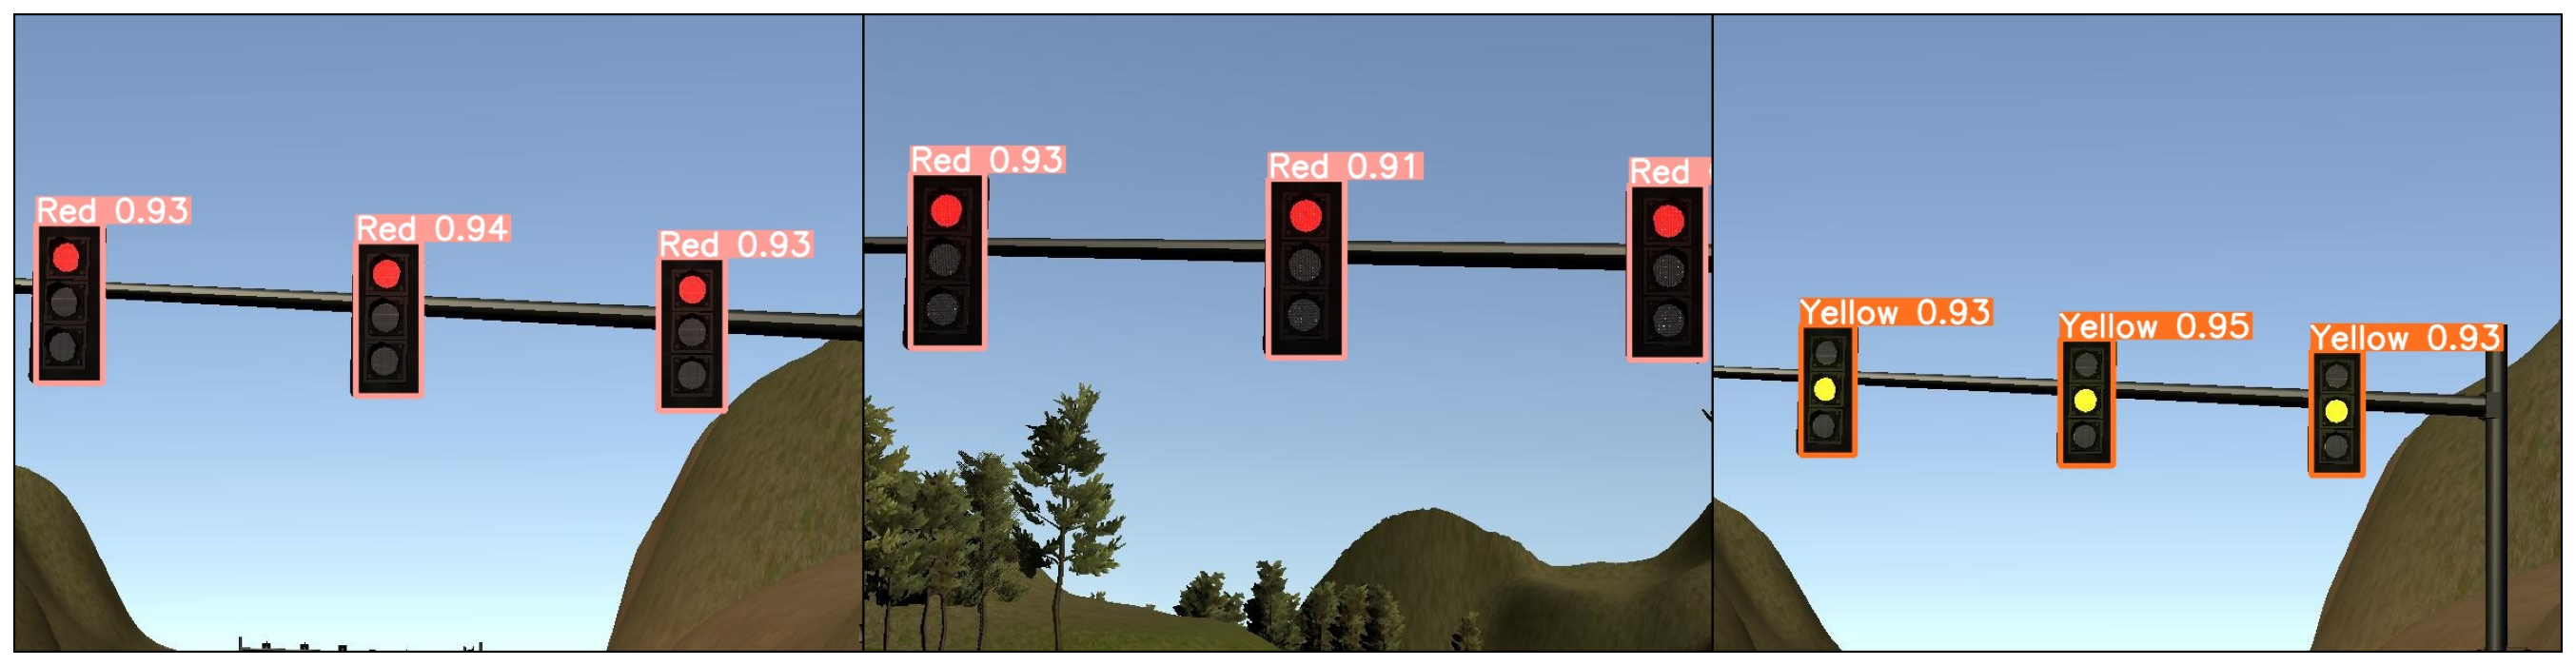

In [47]:
detections_dir = "runs/detect/yolo_lights5/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
show_grid(detection_images[3:6])

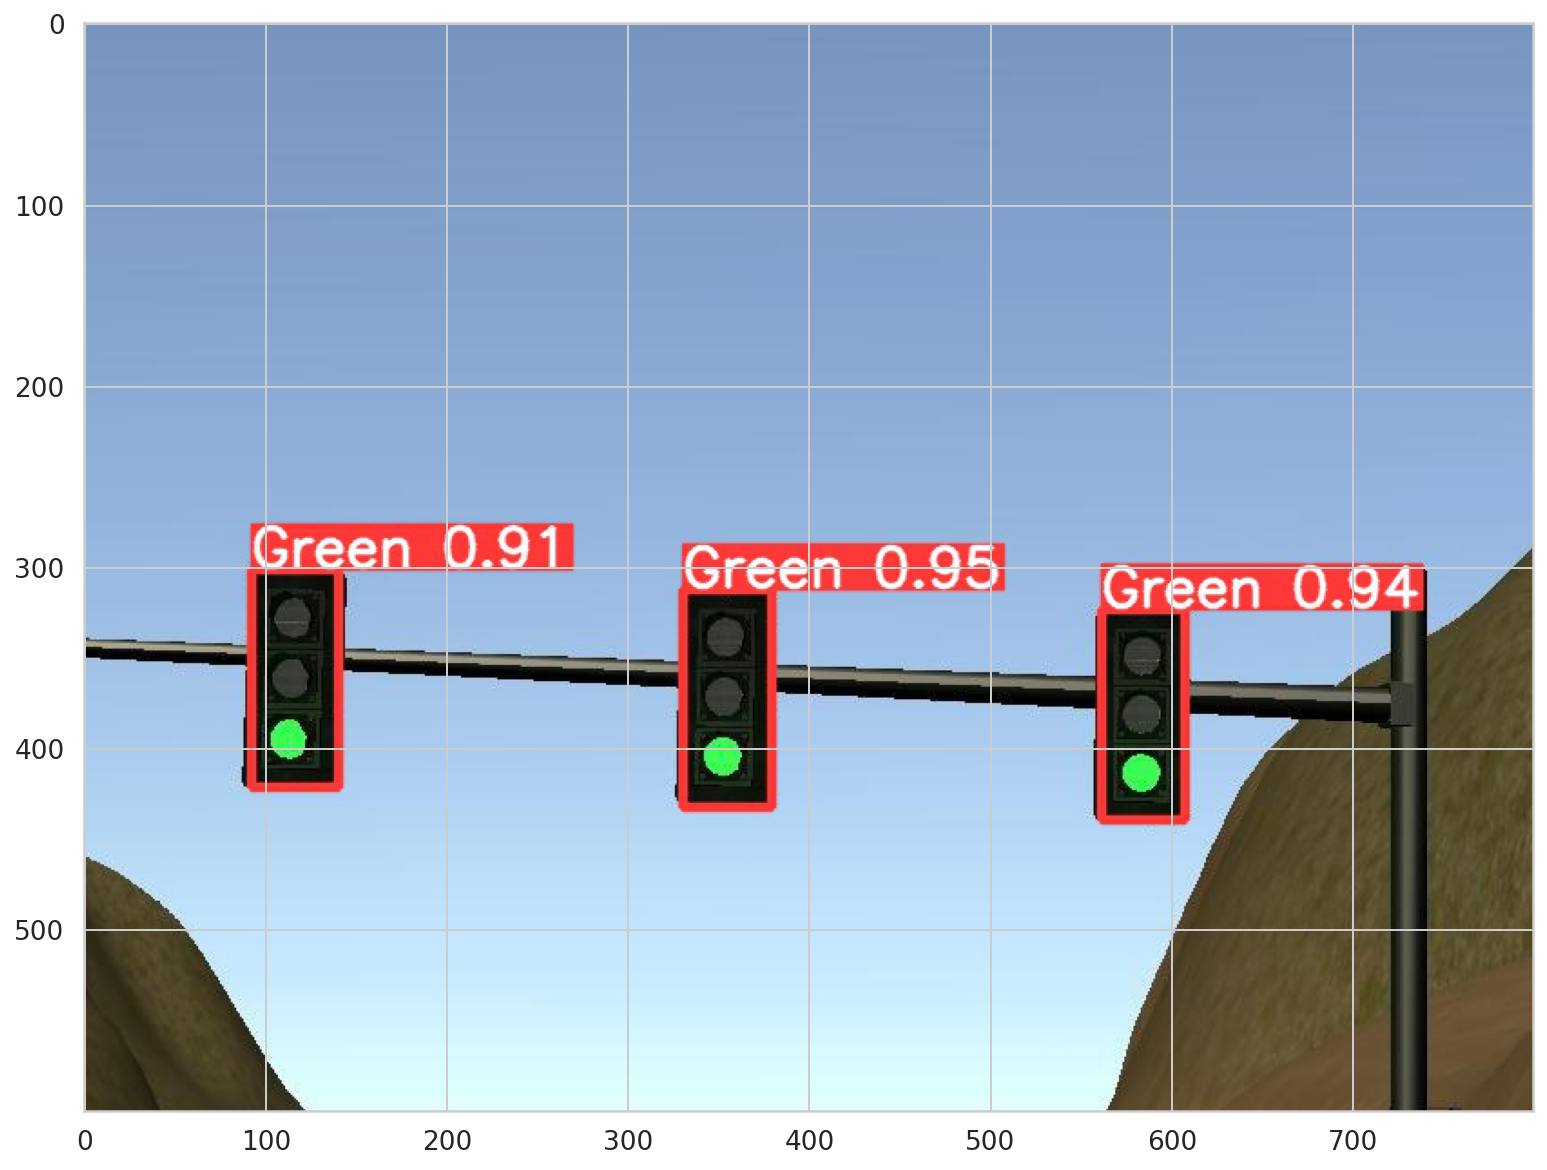

In [49]:
detections_dir = "runs/detect/yolo_lights5/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]
import time

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))
